In [3]:
import numpy as np
import logging
import nibabel as nib
import math
import matplotlib.pyplot as plt
from numpy import linalg as LA
from skimage.segmentation import slic
from pathlib import Path
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from tqdm import tqdm_notebook as tqdm

In [17]:
def various_crop(img, label, least_size):
    """
    Args:
        img: (numpy.ndarray)
    Returns:
        cropped_img: (numpy.ndarray)
    """
    h_size = img.shape[0]
    w_size = img.shape[1]
    anchor = [0, h_size, 0, w_size]
    line_w = img.sum(0)
    line_h = img.sum(1)
    flag = False
    for i in range(h_size):
        if flag==False and line_h[i]!=0:
            anchor[0] = i
            flag = True
        elif flag==True and line_h[i]==0:
            anchor[1] = i
            flag = False
            break;
    flag = False
    for i in range(w_size):
        if flag==False and line_w[i]!=0:
            anchor[2] = i
            flag = True
        elif flag==True and line_w[i]==0:
            anchor[3] = i
            flag = False
            break;
    h_up, h_down, w_left, w_right = anchor
    if (h_down - h_up) < least_size:
        h_down = h_up + least_size
    if (w_right - w_left) < least_size:
        w_right = w_left + least_size
    return img[h_up:h_down, w_left:w_right], label[h_up:h_down, w_left:w_right]


def max_min_normalize(img):
    img = np.asarray(img)
    return (img-np.min(img)) / ((np.max(img)-np.min(img) + 1e-10))


def value_count(arr, num):
    """
    Args:
        arr: value 0~1 (numpy.ndarray)
    Returns:
        arr of value count: (numpy.ndarray)
    """
    arr = arr.flatten()
    arr = (arr * (num-1)).astype(np.int32)
    cnt_arr = np.zeros(num).astype(np.int32)
    for i in range(arr.shape[0]):
        cnt_arr[arr[i]] += 1
    return cnt_arr / (cnt_arr.max() + 1e-10)


def feature_extract(img, segments, v_num, f_num):
    features = np.zeros((v_num, f_num))
    for i in range(v_num):
        area = img[np.where(segments==i)]
        features[i] = value_count(area, f_num)
    return features 


def adj_generate(features, segments, tao, threshold):
    centroid = []
    range_num = features.shape[0] if features.shape[0] < (segments.max()+1) else (segments.max()+1)
    for i in range(range_num):
        centroid.append((np.where(segments==i)[0].mean(), np.where(segments==i)[1].mean()))
    centroid = np.asarray(centroid)
    adj_arr = np.zeros((features.shape[0], features.shape[0]))
    for i in range(range_num):
        for j in range(i+1, range_num):
            if LA.norm(centroid[i] - centroid[j]) > (segments.shape[0]*threshold):
                adj_arr[i, j] = 0
            else:
                e_dist = LA.norm((features[i] - features[j]))
                tmp = -1 * e_dist * e_dist / (2*tao*tao)
                adj_arr[i, j] = math.exp(tmp)
            adj_arr[j, i] = adj_arr[i, j]
    adj_arr += np.eye(features.shape[0])
    return adj_arr


def label_transform(label, segments, v_num, f_num):
    gcn_label = np.zeros((v_num, 1))
    n_range = int(np.minimum(v_num, segments.max()+1))
    for i in range(n_range):
        gcn_label[i] = int(np.median(label[np.where(segments==i)]))
    return gcn_label

In [21]:
data_dir = Path('/home/tony/Documents/IBSR_preprocessed/')
output_dir = Path('/home/tony/Documents/IBSR_preprocessed_2d/')
paths = [path for path in data_dir.iterdir() if path.is_dir()]
paths

[PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_12'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_16'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_10'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_18'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_08'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_03'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_13'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_11'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_15'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_07'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_09'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_06'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_14'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_17'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_02'),
 PosixPath('/home/tony/Documents/IBSR_preprocessed/IBSR_01'),
 PosixPa

In [23]:
IMG_MIN_SIZE = 64
N_SEG = 512
COMPACTNESS = 10
N_VERTEX = 512
N_FEATURES = 128
TAO = 0.5
THRESHOLD = 0.5

for path in paths:
    #logging.info(f'Process {path.parts[-1]}.')
    print(f'Process {path.parts[-1]}.')
    # Create output directory
    if not (output_dir / path.parts[-1]).is_dir():
        (output_dir / path.parts[-1]).mkdir(parents=True)

    # Read in the MRI scans
    image = nib.load(str(path / 'image.nii.gz')).get_data().astype(np.float32)
    image = np.squeeze(image, 3)
    image = image.transpose(2, 0, 1)
    label = nib.load(str(path / 'label.nii.gz')).get_data().astype(np.uint8)
    label = np.squeeze(label, 3)
    label = label.transpose(2, 0, 1)

    # Save each slice of the scan into single file
    for s in tqdm(range(image.shape[0])):
        if s>=5 and s<=115:
            _image = image[s]
            _label = label[s]
            
            img_crop, label_crop = various_crop(_image, _label, IMG_MIN_SIZE)
            img_crop = max_min_normalize(img_crop)
            img_3c = np.expand_dims(img_crop, axis=2)
            img_3c = np.concatenate((img_3c, img_3c, img_3c), 2)
            
            segments = slic(img_3c.astype('double'), n_segments=N_SEG, compactness=COMPACTNESS)
            #features = feature_extract(img_crop, segments, N_VERTEX, N_FEATURES)
            #adj_arr = adj_generate(features, segments, TAO, THRESHOLD)
            
            gcn_label = label_transform(label_crop, segments, N_VERTEX, N_FEATURES)
            
            #np.save(str(output_dir / path.parts[-1] / f'image_{s}.npy'), img_crop)
            np.save(str(output_dir / path.parts[-1] / f'label_{s}.npy'), label_crop)
            np.save(str(output_dir / path.parts[-1] / f'gcn_label_{s}.npy'), gcn_label)
            #np.save(str(output_dir / path.parts[-1] / f'segments_{s}.npy'), segments)
            #np.save(str(output_dir / path.parts[-1] / f'features_{s}.npy'), features)
            #np.save(str(output_dir / path.parts[-1] / f'adj_arr_{s}.npy'), adj_arr)


Process IBSR_12.



Process IBSR_16.



Process IBSR_10.



Process IBSR_18.



Process IBSR_08.



Process IBSR_03.



Process IBSR_13.



Process IBSR_11.



Process IBSR_15.



Process IBSR_07.



Process IBSR_09.



Process IBSR_06.



Process IBSR_14.



Process IBSR_17.



Process IBSR_02.



Process IBSR_01.



Process IBSR_04.



Process IBSR_05.


In [62]:
path = Path('/home/tony/Documents/kits19/data/case_00193')
image = nib.load(str(path / 'imaging.nii.gz')).get_data().astype(np.float32)
label = nib.load(str(path / 'segmentation.nii.gz')).get_data().astype(np.uint8)

In [64]:
image.shape

(233, 512, 512)

In [32]:
def label_reconstruct_2d(label, segments):
    label_recon = np.zeros((label.shape[0], label.shape[1]))
    id_list = list(np.unique(segments))
    for i in id_list:
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

def label_reconstruct_3d(label, segments):
    label_recon = np.zeros((label.shape[0], label.shape[1], label.shape[2]))
    for i in range(segments.max()+1):
        label_recon[np.where(segments==i)] = int(np.median(label[np.where(segments==i)].flatten()))
    return label_recon

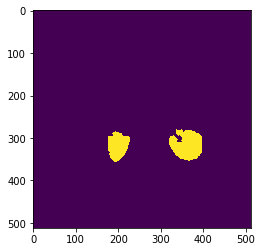

In [59]:
img = image[92]
img = max_min_normalize(img)
lab = label[92]
segments = slic(img.astype('double'), n_segments=2048, compactness=0.05)
recon = label_reconstruct_2d(lab, segments)
plt.imshow(recon)

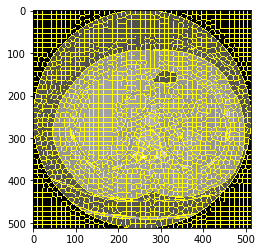

In [57]:
plt.imshow(mark_boundaries(img, segments))

(98, 512, 512)

In [32]:
_dir = Path('/home/tony/Documents/IBSR_preprocessed_2d/IBSR_11')
image = np.load(_dir / f'image_{50}.npy').astype(np.float32)
label = np.load(_dir / f'label_{50}.npy').astype(np.int32)
gcnlabel = np.load(_dir / f'gcn_label_{50}.npy').astype(np.int32)
segments = np.load(_dir / f'segments_{50}.npy').astype(np.float32)
features = np.load(_dir / f'features_{50}.npy').astype(np.float32)
adj_arr = np.load(_dir / f'adj_arr_{50}.npy').astype(np.float32)

In [38]:
import torch
def label2img(output, segments):
    #output = torch.argmax(output, axis=1)
    n_range = output.size(0) if output.size(0)<segments.max()+1 else segments.max()+1

    img = torch.zeros_like(segments)
    mask0 = torch.zeros_like(segments)
    mask1 = torch.ones_like(segments)

    for i in range(n_range):
        img += torch.where(segments==i, output[i]*mask1, mask0)

    return img

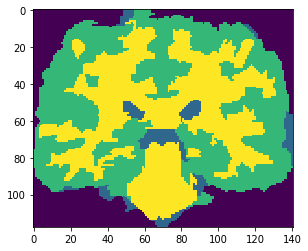

In [39]:
gcnlabel = torch.LongTensor(gcnlabel)
segments = torch.LongTensor(segments)
img = label2img(gcnlabel, segments)
plt.imshow(np.asarray(img))

In [30]:
gcnlabel

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [2],
       [3],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [2],
       [2],
       [2],
       [3],
       [2],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [0],
       [0],
       [2],
       [3],
       [2],
       [2],
       [2],
       [3],
       [2],
       [2],
       [2],
       [3],
       [2],
       [2],
       [3],
       [2],
       [3],
       [3],
       [0],
       [2],
       [0],
       [2],
       [3],
    

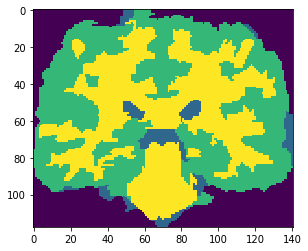

In [19]:
def label_transform(label, segments, v_num, f_num):
    gcn_label = np.zeros((v_num, 1))
    n_range = int(np.minimum(v_num, segments.max()+1))
    for i in range(n_range):
        gcn_label[i] = int(np.median(label[np.where(segments==i)]))
    return gcn_label


gcn_label = label_transform(label, segments, 512, 64)
label_recon = np.zeros((label.shape[0], label.shape[1]))
n_range = int(np.minimum(features.shape[0], segments.max()+1))
for i in range(n_range):
    label_recon[np.where(segments==i)] = gcn_label[i]
plt.imshow(label_recon)

In [15]:
segments.shape

(118, 141)

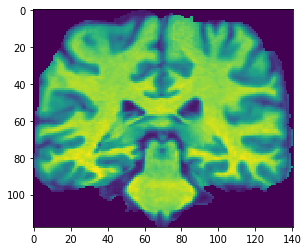

In [5]:
plt.imshow(image)

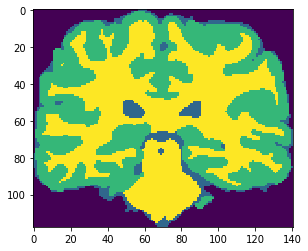

In [10]:
plt.imshow(label)

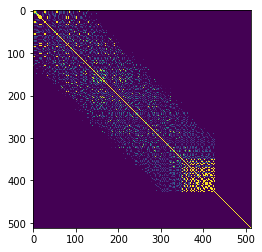

In [11]:
plt.imshow(adj_arr)

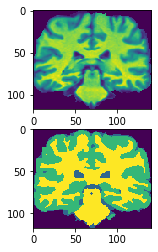

In [12]:
plt.subplot(211)
plt.imshow(image)
plt.subplot(212)
plt.imshow(label)

In [13]:
img_crop, label_crop = various_crop(image, label, 100)
img_crop = max_min_normalize(img_crop)
img_3c = np.expand_dims(img_crop, axis=2)
img_3c = np.concatenate((img_3c, img_3c, img_3c), 2)

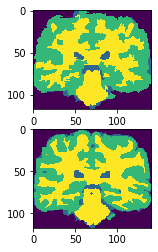

In [14]:
n_seg = 512
compact = 10
segments = slic(img_3c.astype('double'), n_segments=n_seg, compactness=compact)
label_recon = np.zeros((label_crop.shape[0], label_crop.shape[1]))
for i in range(segments.max()+1):
    label_recon[np.where(segments==i)] = int(np.median(label_crop[np.where(segments==i)]))
plt.subplot(211)
plt.imshow(label_recon)
plt.subplot(212)
plt.imshow(label_crop)

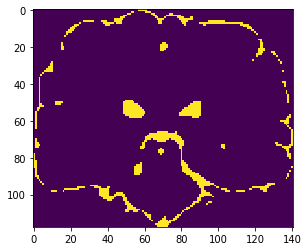

In [17]:
test = label_crop.copy()
test[np.where(test!=1)] = 0
plt.imshow(test)